## Table of Contents

1. **NumPy Basics**
   - 1.1 Arrays, dtypes, shapes, reshape
   - 1.2 Indexing, slicing
   - 1.3 Boolean & fancy indexing; views vs copies
   - 1.4 Broadcasting & vectorization
   - 1.5 Concatenate, split, sort, stats
   - 1.6 Random generator (default_rng), reproducibility
   - 1.7 Quick visualizations
   - 1.8 Exercises

2. **Pandas Basics**
   - 2.1 Series & DataFrame
   - 2.2 CSV I/O (parse_dates, na_values)
   - 2.3 Indexing & selection (.loc/.iloc/.query), new columns
   - 2.4 EDA & basic charts
   - 2.5 Sort, nlargest, duplicates
   - 2.6 Exercises

3. **Advanced Cleaning & Time Series**
   - 3.1 Missing values: dropna, fillna, interpolate, ffill/bfill (per group)
   - 3.2 Duplicates, dtype normalization, rename, reindex
   - 3.3 Strings: strip/replace/extract; categories; one‑hot
   - 3.4 Outliers: IQR, winsorize, MAD
   - 3.5 Merge/Join; anti & semi join; groupby; pivot/melt; crosstab
   - 3.6 Rolling/expanding/EWM; resample; gaps & reindex
   - 3.7 Performance & safety: vectorization vs .apply, .assign/.query/.eval, memory optimization
   - 3.8 Timezones & DST
   - 3.9 Chunked CSV processing
   - 3.10 `merge_asof` for nearest timestamp joins

4. **Case Studies**
   - 4.1 Retail daily sales: clean + MA + resample
   - 4.2 Customers & transactions: CLV‑like aggregation
   - 4.3 A/B testing: conversions, timestamps, z‑test
   - 4.4 Messy CSV: currencies (unicode minus, parentheses negatives), mixed dates
   - 4.5 Missingness matrix visualization
   - 4.6 Text normalization (names, email/phone, split city/state)
   - 4.7 Time series gaps & aggregates (W/M)
   - 4.8 IoT spikes: detect via MAD; rolling median smoothing
   - 4.9 Cohort analysis (signups vs retention)
   - 4.10 Event labeling with `merge_asof`

5. **Comprehensive Exercises + Hints**

6. **Quick Cheat Sheet**

7. **Appendix: Common Pitfalls & Fixes**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)

pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 30)
pd.set_option("display.width", 140)

np.random.seed(42)
os.makedirs("data", exist_ok=True)

# Safer writes in Pandas ≥2.0 (avoid chained assignment issues)
try:
    pd.options.mode.copy_on_write = True
    print("copy_on_write enabled")
except Exception as e:
    print("copy_on_write not available:", e)


NumPy: 2.3.2
Pandas: 2.3.1
copy_on_write enabled


### 2.1 Series & DataFrame
Inspect `.info()`, `.describe()`, dtypes, and memory usage.


In [6]:
s = pd.Series([10, 20, 30], index=["a", "b", "c"], name="score")
print(s)

df = pd.DataFrame({
    "id": [1, 2, 3, 4],
    "name": ["An", "Binh", "Chi", "Dung"],
    "age": [23, 35, 29, 41],
    "income": [12.5, 21.0, 15.0, 28.5]
})
print(df)

print("Info:")
print(df.info())
print("Describe (all):")
print(df.describe(include="all"))
print("Memory (deep):")
print(df.memory_usage(deep=True))


a    10
b    20
c    30
Name: score, dtype: int64
   id  name  age  income
0   1    An   23    12.5
1   2  Binh   35    21.0
2   3   Chi   29    15.0
3   4  Dung   41    28.5
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      4 non-null      int64  
 1   name    4 non-null      object 
 2   age     4 non-null      int64  
 3   income  4 non-null      float64
dtypes: float64(1), int64(2), object(1)
memory usage: 260.0+ bytes
None
Describe (all):
              id name        age     income
count   4.000000    4   4.000000   4.000000
unique       NaN    4        NaN        NaN
top          NaN   An        NaN        NaN
freq         NaN    1        NaN        NaN
mean    2.500000  NaN  32.000000  19.250000
std     1.290994  NaN   7.745967   7.123903
min     1.000000  NaN  23.000000  12.500000
25%     1.750000  NaN  27.500000  14.375000
50%     2.500

### 2.2 CSV I/O (parse_dates, na_values)
Save & load CSV with parsed dates; copy a file.


In [7]:
toy = pd.DataFrame({
    "date": pd.date_range("2025-01-01", periods=10, freq="D"),
    "city": ["HCM","HN","HCM","DN","HUE","HN","HCM","DN","HUE","HN"],
    "sales": np.random.randint(50, 150, size=10),
    "discount": np.round(np.random.rand(10)*0.3, 2)
})
toy.to_csv("data/toy_sales.csv", index=False)

df_toy = pd.read_csv("data/toy_sales.csv", parse_dates=["date"])
print(df_toy.head())

df_toy.to_csv("data/toy_sales_copy.csv", index=False)


        date city  sales  discount
0 2025-01-01  HCM    101      0.26
1 2025-01-02   HN    142      0.18
2 2025-01-03  HCM     64      0.21
3 2025-01-04   DN    121      0.01
4 2025-01-05  HUE    110      0.29


### 2.3 Indexing & selection; new columns
Use `.loc/.iloc`, boolean masks, `.assign`, and date parts. Avoid chained assignment; use `.loc`.


In [8]:
df = df_toy.copy()

print(df.loc[:, ["date", "city"]].head())
print(df.iloc[0:3, 0:3])

mask = (df["city"] == "HCM") & (df["sales"] > 80)
print(df[mask].head())

df = (df
      .assign(revenue = df["sales"] * (1 - df["discount"]),
              day = df["date"].dt.day_name()))
print(df.head())

print(df.sort_values(["city", "sales"], ascending=[True, False]).head())


        date city
0 2025-01-01  HCM
1 2025-01-02   HN
2 2025-01-03  HCM
3 2025-01-04   DN
4 2025-01-05  HUE
        date city  sales
0 2025-01-01  HCM    101
1 2025-01-02   HN    142
2 2025-01-03  HCM     64
        date city  sales  discount
0 2025-01-01  HCM    101      0.26
6 2025-01-07  HCM    132      0.06
        date city  sales  discount  revenue        day
0 2025-01-01  HCM    101      0.26    74.74  Wednesday
1 2025-01-02   HN    142      0.18   116.44   Thursday
2 2025-01-03  HCM     64      0.21    50.56     Friday
3 2025-01-04   DN    121      0.01   119.79   Saturday
4 2025-01-05  HUE    110      0.29    78.10     Sunday
        date city  sales  discount  revenue        day
7 2025-01-08   DN    136      0.05   129.20  Wednesday
3 2025-01-04   DN    121      0.01   119.79   Saturday
6 2025-01-07  HCM    132      0.06   124.08    Tuesday
0 2025-01-01  HCM    101      0.26    74.74  Wednesday
2 2025-01-03  HCM     64      0.21    50.56     Friday


### 2.4 EDA & basic charts


Unique cities: ['HCM' 'HN' 'DN' 'HUE']
Counts by city:
 city
HCM    3
HN     3
DN     2
HUE    2
Name: count, dtype: int64
Dataframe:
   city  count        mean     sum
0   DN      2  124.495000  248.99
1  HCM      3   83.126667  249.38
2   HN      3   93.926667  281.78
3  HUE      2   97.330000  194.66


Text(0.5, 1.0, 'Total revenue by city')

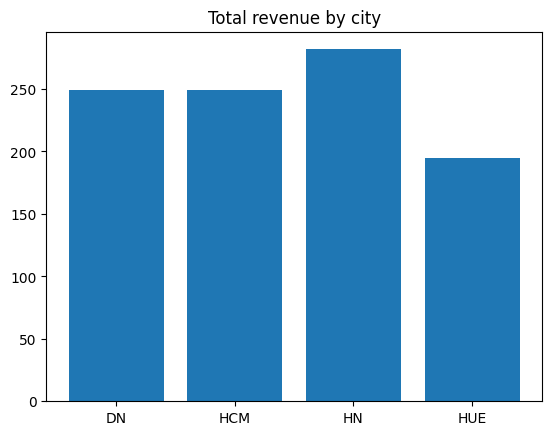

In [ ]:
print("Unique cities:", df["city"].unique())
print("Counts by city:\n", df["city"].value_counts())

g = df.groupby("city")["revenue"].agg(["count","mean","sum"]).reset_index()
print("Dataframe:\n", g)

plt.figure()
plt.bar(g["city"], g["sum"])
plt.title("Total revenue by city")
plt.show()

# plt.figure()
# plt.hist(df["sales"], bins=10)
# plt.title("Sales distribution")
# plt.show()

# plt.figure()
# plt.scatter(df["sales"], df["discount"])
# plt.title("Sales vs Discount")
# plt.show()

# plt.figure()
# df_sorted = df.sort_values("date")
# plt.plot(df_sorted["date"], df_sorted["revenue"])
# plt.title("Revenue over time (toy)")
# plt.xticks(rotation=30)
# plt.show()


### 2.5 Sort, nlargest, duplicates


In [7]:
top5 = df.nlargest(5, "revenue")
print("Top 5 by revenue:\n", top5)

dupes = pd.concat([df_toy, df_toy.iloc[:2]], ignore_index=True)
print("Has duplicates? total rows:", len(dupes), " unique rows:", len(dupes.drop_duplicates()))


Top 5 by revenue:
         date city  sales  discount  revenue        day
7 2025-01-08   DN    136      0.05   129.20  Wednesday
6 2025-01-07  HCM    132      0.06   124.08    Tuesday
3 2025-01-04   DN    121      0.01   119.79   Saturday
8 2025-01-09  HUE    124      0.06   116.56   Thursday
1 2025-01-02   HN    142      0.18   116.44   Thursday
Has duplicates? total rows: 12  unique rows: 10


### 2.6 Exercises
1) From `toy_sales.csv`, compute average **revenue** by `day`. Plot bar.  
2) Create `city_code` mapping `{"HCM":1,"HN":2,"DN":3,"HUE":4}` and sort by it.  
3) Filter top 5 dates by revenue and plot only those dates’ revenue over time.
